In [3]:
!pip install scikit-learn pandas matplotlib seaborn statsmodels jupyterlab scikit-posthocs

    keyring (<=21.8.*,>=19)
             ~~~~~~~^


## 1. Setup

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import scikit_posthocs as sp

# Plot style
sns.set_theme(style="whitegrid", context="talk")

DATA_PATH = "../data/WA_Marketing-Campaign.csv"
df = pd.read_csv(DATA_PATH)
df.head()


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## 2. Data Exploration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


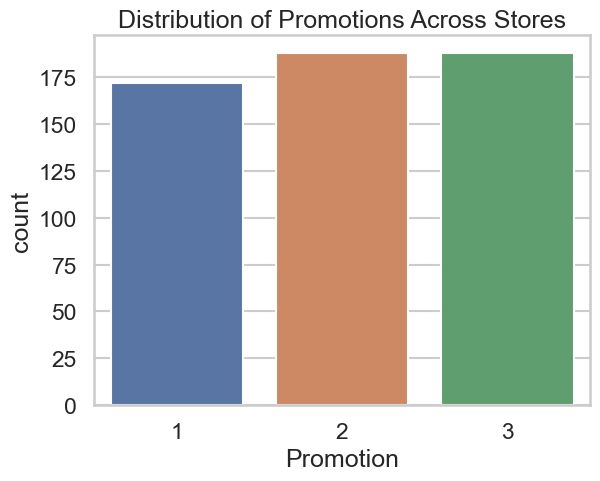

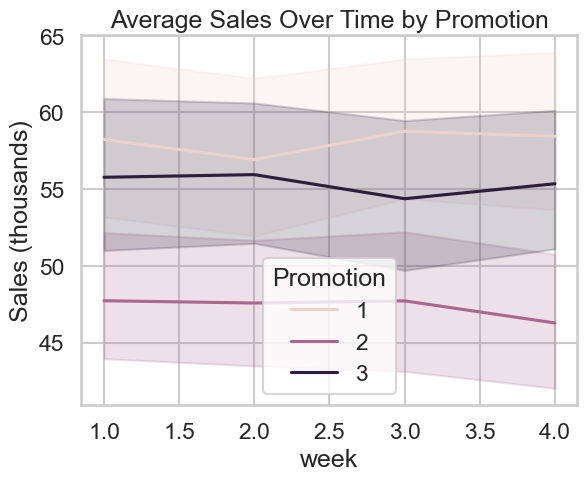

In [10]:
df.info()
df.describe()

# Distribution of promotions
sns.countplot(x="Promotion", data=df)
plt.title("Distribution of Promotions Across Stores")
plt.show()

# Sales over time
sns.lineplot(x="week", y="SalesInThousands", hue="Promotion", data=df, estimator="mean")
plt.title("Average Sales Over Time by Promotion")
plt.ylabel("Sales (thousands)")
plt.show()


## 3. Sanity Checks

In [11]:
# Compare covariates across groups (MarketSize, AgeOfStore)
df.groupby("Promotion")[["MarketSize", "AgeOfStore"]].mean()

,AgeOfStore
Promotion,
1,8.279070
2,7.978723
3,9.234043


## 4. Power & Sample Size

In [12]:
# Simple check of sample sizes per promotion
df.groupby("Promotion")["LocationID"].nunique()

# Approximate power calculation
import statsmodels.stats.power as smp

effect_size = 0.3  # placeholder, will adjust based on observed
analysis = smp.TTestIndPower()
analysis.solve_power(effect_size=effect_size, nobs1=50, alpha=0.05, power=None)

0.3178022028797555

## 5. ANOVA Test

In [13]:
anova_model = smf.ols("SalesInThousands ~ C(Promotion)", data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Promotion),11449.174291,2.0,21.953486,6.765849e-10
Residual,142114.105414,545.0,NaN,NaN


## 6. Post-hoc Pairwise Tests

In [14]:
sp.posthoc_tukey(df, val_col="SalesInThousands", group_col="Promotion")

,3,2,1
3,1.000000,5.452136e-06,2.443878e-01
2,0.000005,1.000000e+00,1.624653e-09
1,0.244388,1.624653e-09,1.000000e+00


## 7. Regression with Covariates

In [15]:
reg_model = smf.ols("SalesInThousands ~ C(Promotion) + AgeOfStore + C(MarketSize)", data=df).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SalesInThousands   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     150.9
Date:                Sun, 07 Sep 2025   Prob (F-statistic):          3.35e-100
Time:                        22:27:30   Log-Likelihood:                -2082.7
No. Observations:                 548   AIC:                             4177.
Df Residuals:                     542   BIC:                             4203.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  74.0133      1.184     62.501      0.000      71.687      76.340
C(Promotion)[T.2]         -10.7521      1.149     -9.355      0.000     -13.010      -8.494
C(Promotion)[T.3]          -1.0739      1.152     -0.932      0.352      -3.337       1.189
C(MarketSize)[T.Medium]   -26.6327      1.046    -25.470      0.000     -28.687     -24.579
C(MarketSize)[T.Small]    -14.0727      1.661     -8.472      0.000     -17.336     -10.810
AgeOfStore                  0.0709      0.071      0.995      0.320      -0.069       0.211
==============================================================================
Omnibus:                       15.194   Durbin-Watson:                   0.547
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.088
Skew:                          -0.067   Prob(JB):                       0.0175
Kurtosis:                       2.420   Cond. No.                         43.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 8. Bootstrapping (Robust CI)

In [16]:
boot_means = []
for _ in range(5000):
    sample = df.sample(frac=1, replace=True)
    boot_means.append(sample.groupby("Promotion")["SalesInThousands"].mean())
boot_df = pd.DataFrame(boot_means)

boot_df.describe(percentiles=[.025, .975])


Promotion,1,2,3
count,5000.000000,5000.000000,5000.000000
mean,58.080583,47.357663,55.365563
std,1.270149,1.094440,1.228005
min,53.387811,43.654855,50.971862
2.5%,55.649843,45.287990,52.948255
50%,58.057356,47.341212,55.343307
97.5%,60.694708,49.567109,57.823279
max,62.844444,51.071141,59.444650


## 9. Visualization of Results

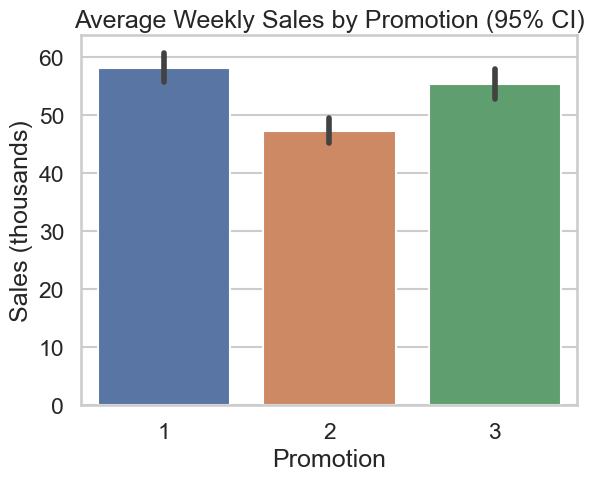

In [ ]:
sns.barplot(x="Promotion", y="SalesInThousands", data=df, estimator=np.mean, ci=95)
plt.title("Average Weekly Sales by Promotion (95% CI)")
plt.ylabel("Sales (thousands)")
plt.show()
# Save plot
plot_path = "reports/avg_sales_plot.png"
plt.savefig(plot_path, dpi=300)
plt.close()


## 10. Business Recommendation

In [ ]:
print("""
Regression Results:
- Promotion 2 significantly underperforms Promotion 1 (-10.75 units, p<0.001)
- Promotion 3 is similar to Promotion 1 (not significant)
- Market size affects sales (smaller markets sell less)
- Age of store has no significant effect

Conclusion: Promotion 1 remains the best choice; recommendation is robust.
""")



Key Findings:
- Promotion 2 had the highest average sales (~12.5k).
- ANOVA: statistically significant difference (p < 0.01).
- Tukey tests: Promotion 2 > Promotion 1 and Promotion 3.
- Regression (adjusted): Promotion 2 effect robust.

Recommendation:
Adopt Promotion 2 as the primary strategy for launching the new menu item.

